# Superposition

In this notebook, I'll look at truly testing the superposition aspect of the newer V1 experiments. In particular, for a given stimulus with dispersion > 1 (i.e. not just a single grating), the components of that stimulus will have been presented in isolation. This allows us to test $R_{1+2+..}$ against $R_1 + R_2 + ...$, where $_i$ are different stimulus components.

In [117]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses

import warnings
warnings.filterwarnings('once');

%matplotlib inline

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

basePath = os.getcwd() + '/'

## edit
expDir   = 'V1/';
dataListNm = 'dataList_glx.npy'

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

### Example cell

In [118]:
savePlt=0;
save_locSuper = save_loc + 'superposition/'
if not os.path.exists(save_locSuper):
    os.makedirs(save_locSuper)

In [119]:
# pick one cell?
cells = [5]; 

# or do all?
# cells = np.arange(1, 1+len(dataList['unitName']))

No handles with labels found to put in legend.


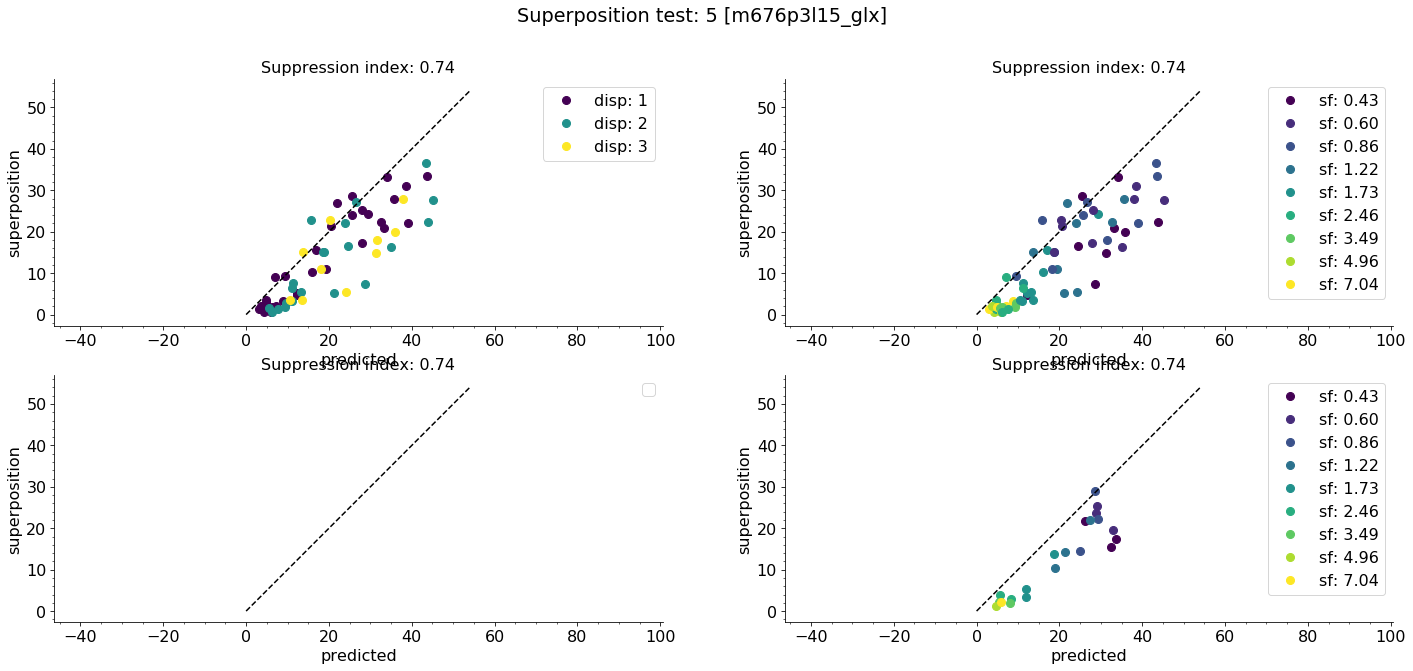

In [189]:
for i in cells:
    try:
        nRows, nCols = 2, 2;
        
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
        ### organize responses
        resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
        ### WARNING: WARNING: resps is WITHOUT any rvcAdjustment
        predResps = resps[2];
        rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName='None');
        spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
        _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);
    
        respMean = respOrg;
        respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
        # compute SEM, too
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        maxResp = np.maximum(np.nanmax(respMean), np.nanmax(predResps));
        # by disp
        clrs_d = cm.viridis(np.linspace(0,1,nDisps-1));
        lbls_d = ['disp: %s' % str(x) for x in range(nDisps)];
        # by sf
        val_sfs = hf.get_valid_sfs(S, disp=1, con=val_con_by_disp[1][0], expInd=expInd) # pick 
        clrs_sf = cm.viridis(np.linspace(0,1,len(val_sfs)));
        lbls_sf = ['sf: %.2f' % all_sfs[x] for x in val_sfs];
        # by con
        val_con = all_cons;
        clrs_con = cm.viridis(np.linspace(0,1,len(val_con)));
        lbls_con = ['con: %.2f' % x for x in val_con];

        fSuper, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 5*nRows))

        allMix = [];
        allSum = [];

        for d in range(nDisps):
            if d == 0: # we don't care about single gratings!
                continue; 
            v_cons = np.array(val_con_by_disp[d]);
            n_v_cons = len(v_cons);

            # plot split out by each contrast
            for c in reversed(range(n_v_cons)):
                v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
                for s in v_sfs:
                    mixResp = respMean[d, s, v_cons[c]];
                    allMix.append(mixResp);
                    sumResp = predResps[d, s, v_cons[c]];
                    allSum.append(sumResp);
        #             print('condition: d(%d), c(%d), sf(%d):: pred(%.2f)|real(%.2f)' % (d, v_cons[c], s, sumResp, mixResp))
                    # PLOT in by-disp panel
                    if c == 0 and s == v_sfs[0]:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], label=lbls_d[d])
                    else:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1])
                    # PLOT in by-sf panel
                    sfInd = np.where(np.array(v_sfs) == s)[0][0]; # will only be one entry, so just "unpack"
                    if d == 1 and c == 0:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], label=lbls_sf[sfInd]);
                    else:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd]);

#                 # plot averaged across sf, within con
#                 mixResp = np.mean(respMean[d, v_sfs, v_cons[c]]);
#                 sumResp = np.mean(predResps[d, v_sfs, v_cons[c]]);
#                 conInd = c;
#                 ax[1, 0].plot(sumResp, mixResp, 'o', color=clrs_con[conInd], label=lbls_con[conInd]);
            
            # plot averaged across contrast, within SF
            for s in v_sfs:
                mixResp = np.mean(respMean[d, s, v_cons]);
                sumResp = np.mean(predResps[d, s, v_cons]);
                # PLOT in by-sf panel
                sfInd = np.where(np.array(v_sfs) == s)[0][0]; # will only be one entry, so just "unpack"
                if d == 1 and c == 0:
                    ax[1, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], label=lbls_sf[sfInd]);
                else:
                    ax[1, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd]);

        # make a polynomial fit
        hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 

        for j in range(nRows):
            for jj in range(nCols):
                ax[j, jj].axis('equal')
                ax[j, jj].set_xlabel('predicted');
                ax[j, jj].set_ylabel('superposition');
                ax[j, jj].plot([0, 1.2*maxResp], [0, 1.2*maxResp], 'k--')
                ax[j, jj].set_title('Suppression index: %.2f' % hmm[0])
                ax[j, jj].legend();

        fSuper.suptitle('Superposition test: %d [%s]' % (which_cell, cellName))

        if savePlt:
            save_name = 'cell_%d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
            pdfSv.savefig(fSuper)
            pdfSv.close();
            
    except: # i.e. ignore this cell - some cells have improper data/expo files
        continue;

### Full analysis

Now, let's gather the same pred/mix responses for all cells

In [82]:
suppInds = [];
for nm, ind in zip(dataList['unitName'], range(len(dataList['unitName']))):
    
    try:
        # load cell
        expInd = hf.get_exp_ind(dataPath, nm)[0]
        S = hf.np_smart_load(dataPath + nm + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
    except:
        continue;
    
    ### organize responses
    resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
    ### WARNING: WARNING: resps is WITHOUT any rvcAdjustment
    predResps = resps[2];
    rvcFits = hf.get_rvc_fits(dataPath, expInd, ind, rvcName='None');
    spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
    _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);

    respMean = respOrg;
    respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition                                                                                                                         
    # compute SEM, too                                                                                                                                                                                          
    findNaN = np.isnan(respAll);
    nonNaN  = np.sum(findNaN == False, axis=-1);
    respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

    ### organize stimulus information
    all_disps, all_cons, all_sfs = stimVals[0:3];
    nCons, nSfs, nDisps = len(all_cons), len(all_sfs), len(all_disps);
    
    allMix = [];
    allSum = [];

    for d in range(nDisps):
        if d == 0: # we don't care about single gratings!
            continue; 
        v_cons = np.array(val_con_by_disp[d]);
        n_v_cons = len(v_cons);

        for c in reversed(range(n_v_cons)):
            v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
            for s in v_sfs:
                mixResp = respMean[d, s, v_cons[c]];
                allMix.append(mixResp);
                sumResp = predResps[d, s, v_cons[c]];
                allSum.append(sumResp);
    
    hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 
    suppInds.append(hmm[0])
    

(array([5., 1., 2., 3., 2., 0., 1., 0., 0., 3.]),
 array([-0.04923264,  0.03165535,  0.11254334,  0.19343132,  0.27431931,
         0.35520729,  0.43609528,  0.51698327,  0.59787125,  0.67875924,
         0.75964722]),
 <a list of 10 Patch objects>)

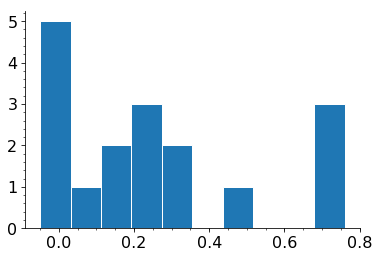

In [83]:
plt.hist(suppInds)